In [60]:
%matplotlib inline
import jax
import jax.numpy as jnp

import galsim
import numpy as np
import proplot as pplt
from fpfs.imgutil import gauss_kernel

In [91]:
def _adaptive_shape_kern(im, sigma2):
    half = ngrid//2
    y, x = jnp.mgrid[:ngrid, :ngrid]
    y = y - half
    x = x - half
    
    kern = jnp.exp(
        -0.5 * x * x / sigma2
        -0.5 * y * y / sigma2
    )
    
    norm = jnp.sum(im * kern)
    mx2 = jnp.sum(x * x * kern * im) / norm
    my2 = jnp.sum(y * y * kern * im) / norm

    
    # It seems that there is many nonlinearity in these operation;
    # Let's see whether we need something modifications to the below equation
    # adaptive moments has this deweighting thing
    # I got this snippet out of ngmix
    idetm = 1.0 / (mx2 * my2)
    idetw = 1.0 / sigma2 / sigma2
    Nrr = mx2*idetm - sigma2*idetw  # Nrr = Icc*idetm - Wcc*idetw
    Ncc = my2*idetm - sigma2*idetw  # Ncc = Irr*idetm - Wrr*idetw
    detn = Nrr*Ncc

    # now set from the inverted matrix
    idetn = 1.0/detn
    mx2 = Ncc*idetn
    my2 = Nrr*idetn
    
    new_sigma2 = (mx2 + my2)/2.0
    
    return new_sigma2


def dumb_adaptive_thing(im):
    # adapitve size
    sigma2 = (2.0/0.2/2.355)**2
    for _ in range(10):
        sigma2 = _adaptive_shape_kern(im, sigma2)
            
    # then shapes
    half = ngrid//2
    y, x = jnp.mgrid[:ngrid, :ngrid]
    y = y - half
    x = x - half
    kern = jnp.exp(
        -0.5 * x * x / sigma2
        -0.5 * y * y / sigma2
    )
    norm = jnp.sum(im * kern)
    mx2 = jnp.sum(x * x * kern * im) / norm
    my2 = jnp.sum(y * y * kern * im) / norm
    mxy = jnp.sum(x * y * kern * im) / norm
    
    meas = jnp.array([(mx2+my2)/2., (mx2-my2)/2., mxy])
    return meas


# Adaptive size estimation and its derivatives
meas_fun = jax.jit(dumb_adaptive_thing)
meas_deriv = jax.jit(jax.jacfwd(dumb_adaptive_thing))

# Gaussian Smoothing
def get_smooth_img(im, smooth_scale_fourier=2.5):
    gsigma=smooth_scale_fourier*2.*np.pi/ngrid
    gKer, (k2grid,k1grid) =gauss_kernel(ngrid,ngrid,gsigma,return_grid=True)
    # convolution
    imF=np.fft.fft2(im)*gKer
    # back to configuration space
    imCov=np.fft.ifft2(imF).real
    return imCov
    
# pixel response in Li & Mandelbaum 2023
def get_shear_response(im, smooth_scale_fourier=2.5):
    gsigma=smooth_scale_fourier*2.*np.pi/ngrid
    gKer, (k2grid,k1grid) =gauss_kernel(ngrid,ngrid,gsigma,return_grid=True)
    # convolution
    imF=np.fft.fft2(im)*gKer
    # shear response of smoothed image
    imFQA=imF*(k1grid**2.-k2grid**2.)/gsigma**2.
    imFQB=imF*(2.*k1grid*k2grid)/gsigma**2.
    imFDA=imF*(-1j*k1grid)
    imFDB=imF*(-1j*k2grid)
    
    # back to configuration space
    imCov=np.fft.ifft2(imF).real
    imCovQA=np.fft.ifft2(imFQA).real
    imCovQB=np.fft.ifft2(imFQB).real
    imCovDA=np.fft.ifft2(imFDA).real
    imCovDB=np.fft.ifft2(imFDB).real
    ygrid,xgrid = np.meshgrid(np.fft.fftfreq(ngrid,1/ngrid),np.fft.fftfreq(ngrid,1/ngrid),indexing='ij')
    xgrid=np.fft.fftshift(xgrid)
    ygrid=np.fft.fftshift(ygrid)
    return imCovQA+xgrid*imCovDA-ygrid*imCovDB

In [92]:
# image
ngrid = 16
obj = galsim.Exponential(half_light_radius=2.).shear(e1=0.1, e2=-0.14).shear(g1=0.03)
im = obj.shift(0.5,0.5).drawImage(nx=ngrid, ny=ngrid, scale=1, method = 'no_pixel').array
im_sm = get_smooth_img(im)

In [94]:
%%time
im_sr = get_shear_response(im)
mm = meas_fun(im_sm)
dmm_dpix = meas_deriv(im_sm)
dmm_dg = jnp.sum(dmm_dpix*im_sr, axis= (1,2))

CPU times: user 10.1 ms, sys: 2.9 ms, total: 13 ms
Wall time: 5.18 ms


Text(0.5, 1.0, '$\\mathrm{d}f_x/\\mathrm{d} \\gamma_1$')

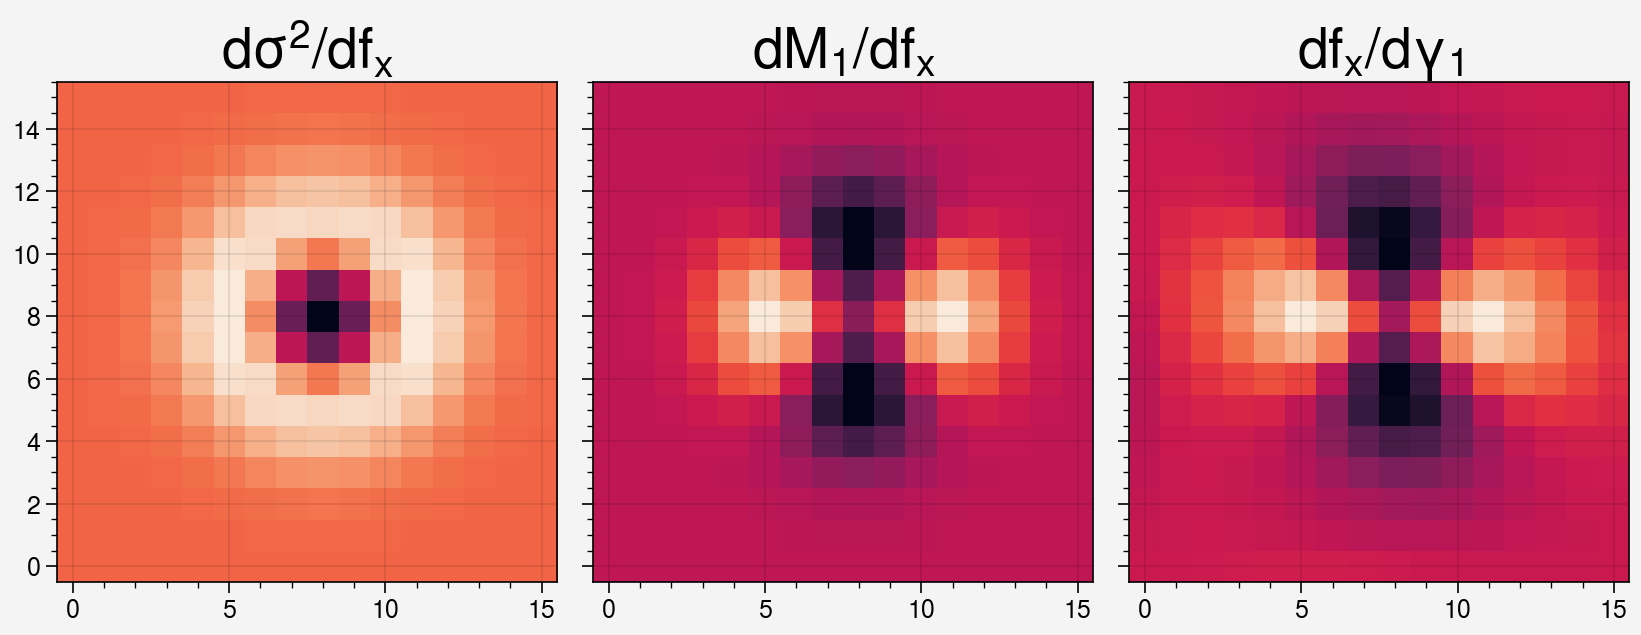

In [95]:
pplt.close()
fig, axs = pplt.subplots(ncols=3, nrows=1)
axs[0].imshow(dmm_dpix[0], origin="lower", cmap="rocket")
axs[0].set_title("$\mathrm{d}\sigma^2/\mathrm{d}f_x$", fontsize = 20)

axs[1].imshow(dmm_dpix[1], origin="lower", cmap="rocket")
axs[1].set_title("$\mathrm{d}M_1/\mathrm{d}f_x$", fontsize = 20)

axs[2].imshow(im_sr, origin="lower", cmap="rocket")
axs[2].set_title("$\mathrm{d}f_x/\mathrm{d} \gamma_1$", fontsize = 20)

In [97]:
%%time
ngrid = 32
mbias_list =[]
hlr_list = np.array([2.,2.5,3.,3.5,4.])
for hlr in hlr_list: 
    # image
    obj = galsim.Exponential(half_light_radius=hlr).shear(g1=0.03)#.shear(e1=0.1, e2=-0.14)
    im = obj.shift(0.5,0.5).drawImage(nx=ngrid, ny=ngrid, scale=1, method = 'no_pixel').array
    im_sm = get_smooth_img(im)
    im_sr = get_shear_response(im)
    mm = meas_fun(im_sm)
    dmm_dpix = meas_deriv(im_sm)
    dmm_dg = jnp.sum(dmm_dpix*im_sr, axis= (1,2))
    mbias = mm[1]/dmm_dg[1]/0.03-1
    print(mbias)
    mbias_list.append(mbias)
mbias_list = np.array(mbias_list)

0.00246487028550213
0.0005189602081405731
-0.0003394740171742683
-0.0006963857495930759
-0.00048222399043662545
CPU times: user 285 ms, sys: 23.6 ms, total: 309 ms
Wall time: 53.5 ms


In [ ]:
pplt.close()
fig, axs = pplt.subplots(ncols=1, nrows=1)
axs[0].plot(hlr_list, mbias_list)
axs[0].set_xlabel('HLR of exponential galaxy')
axs[0].set_ylabel('Multiplicative bias')